<a href="https://colab.research.google.com/github/KetanNag/JP-MORGAN-ONLINE-INTERNSHIP/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
movies = pd.read_csv("/content/movies.csv")
ratings = pd.read_csv("/content/ratings.csv")

In [ ]:
# Display the first few rows of each dataset
print("Movies Dataset:")
print(movies.head())
print("\nRatings Dataset:")
print(ratings.head())

Movies Dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Dataset:
   userId  movieId  rating     timestamp
0       1      296     5.0  1.147880e+09
1       1      306     3.5  1.147869e+09
2       1      307     5.0  1.147869e+09
3       1      665     5.0  1.147879e+09
4       1      899     3.5  1.147869e+09


In [ ]:
final_dataset = ratings.pivot(index='movieId', columns='userId', values='rating')
final_dataset.fillna(0, inplace=True)  # Fill NaN values with 0
print("\nFinal Dataset (User-Item Matrix):")
print(final_dataset.head())


Final Dataset (User-Item Matrix):
userId   1     2     3     4     5     6     7     8     9     10    ...  \
movieId                                                              ...   
1         0.0   3.5   4.0   3.0   4.0   0.0   0.0   4.0   0.0   3.5  ...   
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   5.0   0.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

userId   1746  1747  1748  1749  1750  1751  1752  1753  1754  1755  
movieId                                                              
1         5.0   0.0   4.5   0.0   0.0   0.0   5.0   0.0   3.0   4.5  
2         0.0   0.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   2.5   0.0   0.0   0.0   0.0   0.0   3.5   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.

In [ ]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

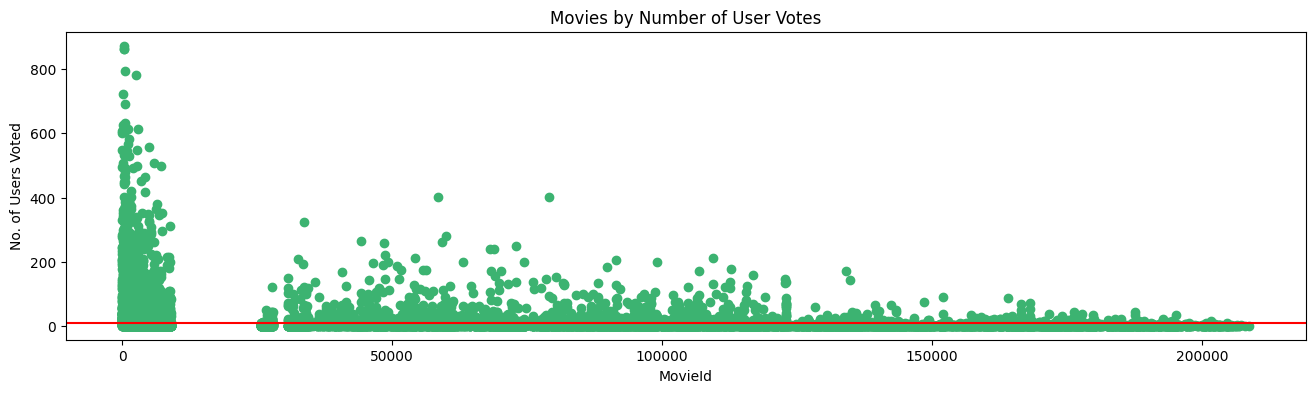

In [ ]:
plt.figure(figsize=(16, 4))
plt.scatter(no_user_voted.index, no_user_voted, color='mediumseagreen')
plt.axhline(y=10, color='red')
plt.xlabel('MovieId')
plt.ylabel('No. of Users Voted')
plt.title('Movies by Number of User Votes')
plt.show()

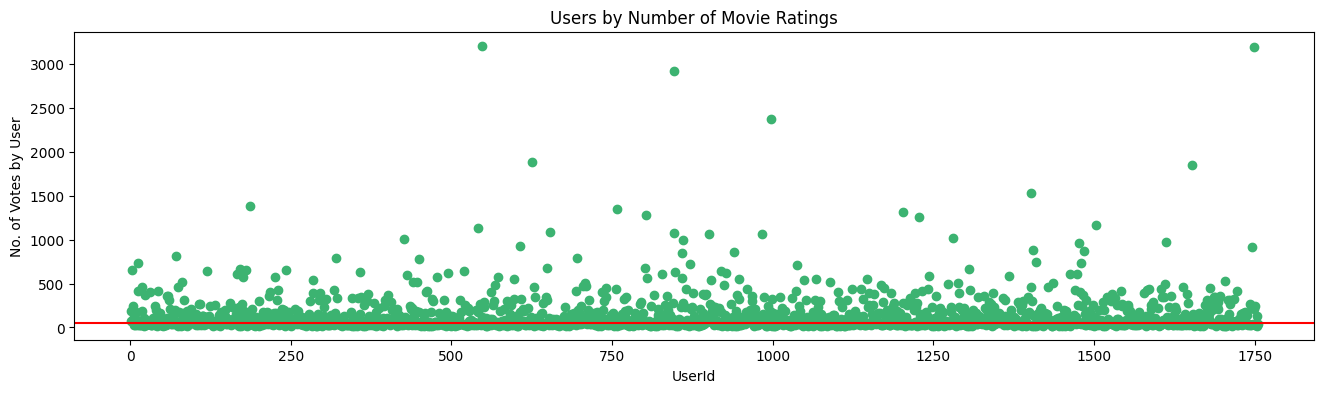

In [ ]:
plt.figure(figsize=(16, 4))
plt.scatter(no_movies_voted.index, no_movies_voted, color='mediumseagreen')
plt.axhline(y=50, color='red')
plt.xlabel('UserId')
plt.ylabel('No. of Votes by User')
plt.title('Users by Number of Movie Ratings')
plt.show()

In [ ]:
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_item_matrix = user_item_matrix.to_numpy()

In [ ]:
np.random.seed(42)
train_matrix = user_item_matrix.copy()
test_matrix = np.zeros(user_item_matrix.shape)

for user_id in range(user_item_matrix.shape[0]):
    rated_movies = np.where(user_item_matrix[user_id] > 0)[0]
    test_indices = np.random.choice(rated_movies, size=int(0.2 * len(rated_movies)), replace=False)
    train_matrix[user_id, test_indices] = 0
    test_matrix[user_id, test_indices] = user_item_matrix[user_id, test_indices]

In [ ]:
def cosine_similarity(user1, user2):
    dot_product = np.dot(user1, user2)
    norm_user1 = np.linalg.norm(user1)
    norm_user2 = np.linalg.norm(user2)
    return dot_product / (norm_user1 * norm_user2) if norm_user1 != 0 and norm_user2 != 0 else 0

In [ ]:
def get_k_nearest_neighbors(train_matrix, target_user_id, k):
    similarities = []
    target_user_ratings = train_matrix[target_user_id]

    for other_user_id in range(train_matrix.shape[0]):
        if other_user_id != target_user_id:  # Don't compare the user with themselves
            similarity = cosine_similarity(target_user_ratings, train_matrix[other_user_id])
            similarities.append((other_user_id, similarity))

    # Sort by similarity in descending order and get top k neighbors
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:k]

In [ ]:
def predict_rating(train_matrix, target_user_id, movie_id, k=5):
    neighbors = get_k_nearest_neighbors(train_matrix, target_user_id, k)
    numerator = 0
    denominator = 0

    for neighbor_id, similarity in neighbors:
        if train_matrix[neighbor_id, movie_id] > 0:
            numerator += similarity * train_matrix[neighbor_id, movie_id]
            denominator += similarity

    return numerator / denominator if denominator != 0 else 0


In [ ]:
def evaluate_knn(train_matrix, test_matrix, k=5):
    total_squared_error = 0
    count = 0

    for user_id in range(test_matrix.shape[0]):
        for movie_id in range(test_matrix.shape[1]):
            if test_matrix[user_id, movie_id] > 0:  # Only predict for movies in the test set
                predicted_rating = predict_rating(train_matrix, user_id, movie_id, k)

                # Handle potential division by zero in predict_rating
                if predicted_rating is not None and not np.isnan(predicted_rating):
                    total_squared_error += (predicted_rating - test_matrix[user_id, movie_id]) ** 2
                    count += 1

    mse = total_squared_error / count if count != 0 else 0  # Handle zero count to prevent ZeroDivisionError
    return mse
mse = evaluate_knn(train_matrix, test_matrix, k=5)
print(f"Mean Squared Error of KNN model: {mse:.4f}")

Mean Squared Error of KNN model: 5.2792


In [ ]:
def recommend_movies(user_id, k=5, num_recommendations=5):
    user_ratings = train_matrix[user_id]
    unrated_movies = np.where(user_ratings == 0)[0]
    movie_scores = {}

    for movie_id in unrated_movies:
        movie_scores[movie_id] = predict_rating(train_matrix, user_id, movie_id, k)

    recommended_movie_ids = sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]
    recommended_movie_ids = [movie_id for movie_id, score in recommended_movie_ids]

     # Get the movie titles for recommended movie IDs
    recommendations = movies[movies['movieId'].isin(recommended_movie_ids)][['title', 'genres']]
    return recommendations


In [ ]:
print("\nTop movie recommendations for User 1:")
print(recommend_movies(user_id=1, k=5, num_recommendations=5))


Top movie recommendations for User 1:
                                                title          genres
226                       Death and the Maiden (1994)  Drama|Thriller
513                     Road to Wellville, The (1994)          Comedy
543   Thirty-Two Short Films About Glenn Gould (1993)   Drama|Musical
1053              Monty Python's Life of Brian (1979)          Comedy


In [ ]:
import numpy as np

# ... (Your existing functions: predict_rating, evaluate_knn, recommend_movies) ...

def main():
    print("Welcome to the Movie Recommendation System!")

    while True:
        try:
            user_id = int(input("\nEnter the User ID for recommendations (1-{}): ".format(user_item_matrix.shape[0])))
            if user_id < 1 or user_id > user_item_matrix.shape[0]:
                print("Invalid User ID. Please enter a value between 1 and {}.".format(user_item_matrix.shape[0]))
                continue

            # Get recommendations
            print(f"\nTop movie recommendations for User {user_id}:")
            recommendations = recommend_movies(user_id=user_id, k=5, num_recommendations=5) # Corrected function call
            print(recommendations)

            # Prompt to continue or exit
            cont = input("\nWould you like to get recommendations for another user? (yes/no): ").strip().lower()
            if cont != 'yes':
                print("\nThank you for using the Movie Recommendation System!")
                break

        except ValueError:
            print("Invalid input. Please enter a valid User ID.")

# Run the main function
if __name__ == "__main__":
    main()

Welcome to the Movie Recommendation System!
